This notebook trains a random forest model to predict the binning label of each image based on the features extracted from the cell profiling pipeline. 
The model is trained on a balanced dataset, where each binning label is represented equally. 
The dataset is split into training, validation, and test sets, and the model's performance is evaluated on the test set.
The predicted bins are used to adjust the segmentation parameters for each image, which is expected to improve the segmentation quality.

In [1]:
import argparse
import json
import os
import pathlib
import sys
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from organoid_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
def read_labels(infile: str) -> dict:
    """
    Description
    ----------
    Read labels from a parquet file.
    Parameters
    ----------
    infile : str
        Path to the input parquet file.
    Returns
    -------
    dict
        Dictionary containing the labels.
    """
    data = pd.read_parquet(infile).to_dict(orient="list")
    return data

In [3]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [4]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot/NF1_organoid_data")).resolve(),
    root_dir,
)
patient_list_file_path = pathlib.Path(f"{root_dir}/data/patient_IDs.txt").resolve(
    strict=True
)
raw_image_base_dir = pathlib.Path(f"{image_base_dir}/data/").resolve()

In [ ]:
labels_save_file = pathlib.Path(
    "../image_labels/organoid_image_labels.parquet"
).resolve(strict=True)
all_features_save_path = pathlib.Path(
    f"../../3.cellprofiling/results/all_features.parquet"
).resolve(strict=True)
labels = read_labels(labels_save_file)
labels_df = pd.DataFrame(labels)
labels_df
all_features_df = pd.read_parquet(all_features_save_path)
all_features_df
df = pd.merge(
    all_features_df,
    labels_df,
    on=["patient", "well_fov"],
    how="right",
)
# drop rows with na
df = df.dropna(subset=["label"])

In [ ]:
# down sample the training group to be class balanced
class_counts = df["label"].value_counts()
min_count = class_counts.min()

df = (
    df.groupby("label", group_keys=True)
    .apply(lambda x: x.sample(n=min_count, random_state=0))
    .reset_index()
)

df["label"].value_counts()

label
elongated            58
globular             58
small/dissociated    58
Name: count, dtype: int64

In [ ]:
# set up data splits
# train: 80%, val: 10%, test: 10%
# stratify by label, patient

train_df, test_df = train_test_split(
    df,
    test_size=0.10,
    random_state=0,
    stratify=df[["label", "patient"]],
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1111,  # 0.1111 * 0.90 = 0.10 (10% test)
    random_state=0,
    stratify=train_df[["label", "patient"]],
)
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 138
Validation size: 18
Test size: 18


In [8]:
# train a random forest classifier for the organoid labels


rf_model = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_model.fit(
    train_df.drop(columns=["patient", "well_fov", "label", "annotator"]),
    train_df["label"],
)
val_preds = rf_model.predict(
    val_df.drop(columns=["patient", "well_fov", "label", "annotator"])
)
print("Validation Classification Report:")
print(classification_report(val_df["label"], val_preds))
print("Validation Confusion Matrix:")
print(confusion_matrix(val_df["label"], val_preds))
test_preds = rf_model.predict(
    test_df.drop(columns=["patient", "well_fov", "label", "annotator"])
)
print("Test Classification Report:")
print(classification_report(test_df["label"], test_preds))
print("Test Confusion Matrix:")
print(confusion_matrix(test_df["label"], test_preds))

Validation Classification Report:
                   precision    recall  f1-score   support

        elongated       0.80      0.80      0.80         5
         globular       0.55      0.86      0.67         7
small/dissociated       0.50      0.17      0.25         6

         accuracy                           0.61        18
        macro avg       0.62      0.61      0.57        18
     weighted avg       0.60      0.61      0.56        18

Validation Confusion Matrix:
[[4 1 0]
 [0 6 1]
 [1 4 1]]
Test Classification Report:
                   precision    recall  f1-score   support

        elongated       0.83      0.71      0.77         7
         globular       0.71      0.83      0.77         6
small/dissociated       0.40      0.40      0.40         5

         accuracy                           0.67        18
        macro avg       0.65      0.65      0.65        18
     weighted avg       0.67      0.67      0.67        18

Test Confusion Matrix:
[[5 0 2]
 [0 5 1]
 [1 2 2]

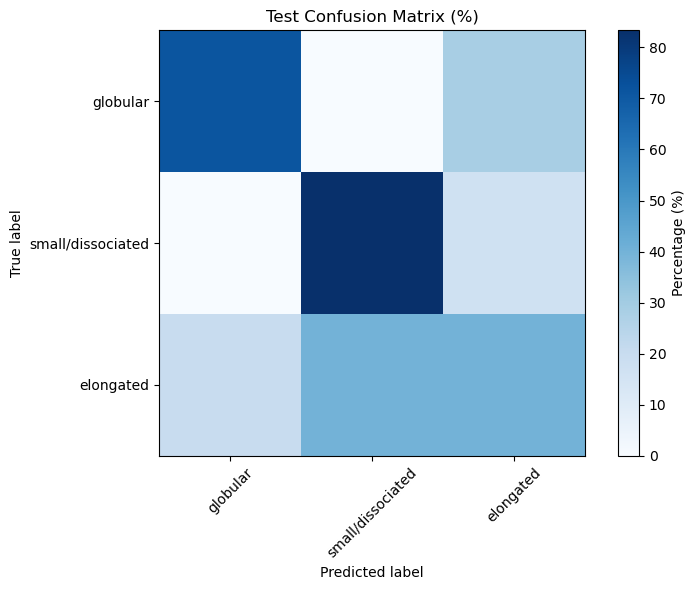

In [ ]:
# plot the confusion matrix for the test set (row-normalized to percentages)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_df["label"], test_preds)
cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100

im = plt.imshow(cm_pct, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix (%)")
cbar = plt.colorbar(im)
cbar.set_label("Percentage (%)")

tick_marks = np.arange(3)
plt.xticks(tick_marks, ["globular", "small/dissociated", "elongated"], rotation=45)
plt.yticks(tick_marks, ["globular", "small/dissociated", "elongated"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

In [10]:
# concatenate the train, val, test df with the predections
train_preds = rf_model.predict(
    train_df.drop(columns=["patient", "well_fov", "label", "annotator"])
)

train_out = train_df.assign(split="train", prediction=train_preds)
val_out = val_df.assign(split="val", prediction=val_preds)
test_out = test_df.assign(split="test", prediction=test_preds)

all_preds_df = pd.concat([train_out, val_out, test_out], ignore_index=True)
all_preds_df["image_path"] = all_preds_df.apply(
    lambda row: pathlib.Path(
        f"{raw_image_base_dir}/{row['patient']}/zstack_images/"
        f"{row['well_fov']}/{row['well_fov']}_555.tif"
    ).resolve(),
    axis=1,
)
all_preds_df.head()

,label,level_1,patient,well_fov,405_CHAMI75_feature_0,405_CHAMI75_feature_1,405_CHAMI75_feature_10,405_CHAMI75_feature_100,405_CHAMI75_feature_101,405_CHAMI75_feature_102,...,TRANS_SAMMed3D_feature_94,TRANS_SAMMed3D_feature_95,TRANS_SAMMed3D_feature_96,TRANS_SAMMed3D_feature_97,TRANS_SAMMed3D_feature_98,TRANS_SAMMed3D_feature_99,annotator,split,prediction,image_path
0,elongated,556,NF0014_T2,F5-4,-1.380481,-0.472573,4.709093,-1.531439,3.510796,3.374955,...,0.005273,-0.074963,0.049897,0.150602,0.435015,0.092533,Mike,train,elongated,/home/lippincm/mnt/bandicoot/NF1_organoid_data...
1,small/dissociated,1031,NF0021_T1,D2-7,-0.941371,-0.350108,4.178493,1.451101,4.755638,4.144989,...,0.006296,-0.070227,0.050383,0.148138,0.436461,0.098357,Mike,train,small/dissociated,/home/lippincm/mnt/bandicoot/NF1_organoid_data...
2,globular,445,NF0030_T1,F8-4,-0.795329,-0.171433,5.291900,2.674886,4.279464,4.482800,...,0.013465,-0.066695,0.078359,0.153885,0.417908,0.116169,Mike,train,globular,/home/lippincm/mnt/bandicoot/NF1_organoid_data...
3,small/dissociated,434,NF0030_T1,F6-1,-2.399410,-0.703916,0.700972,0.177813,4.513484,2.889771,...,0.008693,-0.058742,0.061842,0.195648,0.433364,0.162349,Mike,train,small/dissociated,/home/lippincm/mnt/bandicoot/NF1_organoid_data...
4,elongated,62,NF0014_T1,F10-1,4.869580,-2.873573,3.169348,-0.103742,3.424017,0.892134,...,0.008177,-0.037016,0.068270,0.162929,0.427570,0.126286,Mike,train,elongated,/home/lippincm/mnt/bandicoot/NF1_organoid_data...


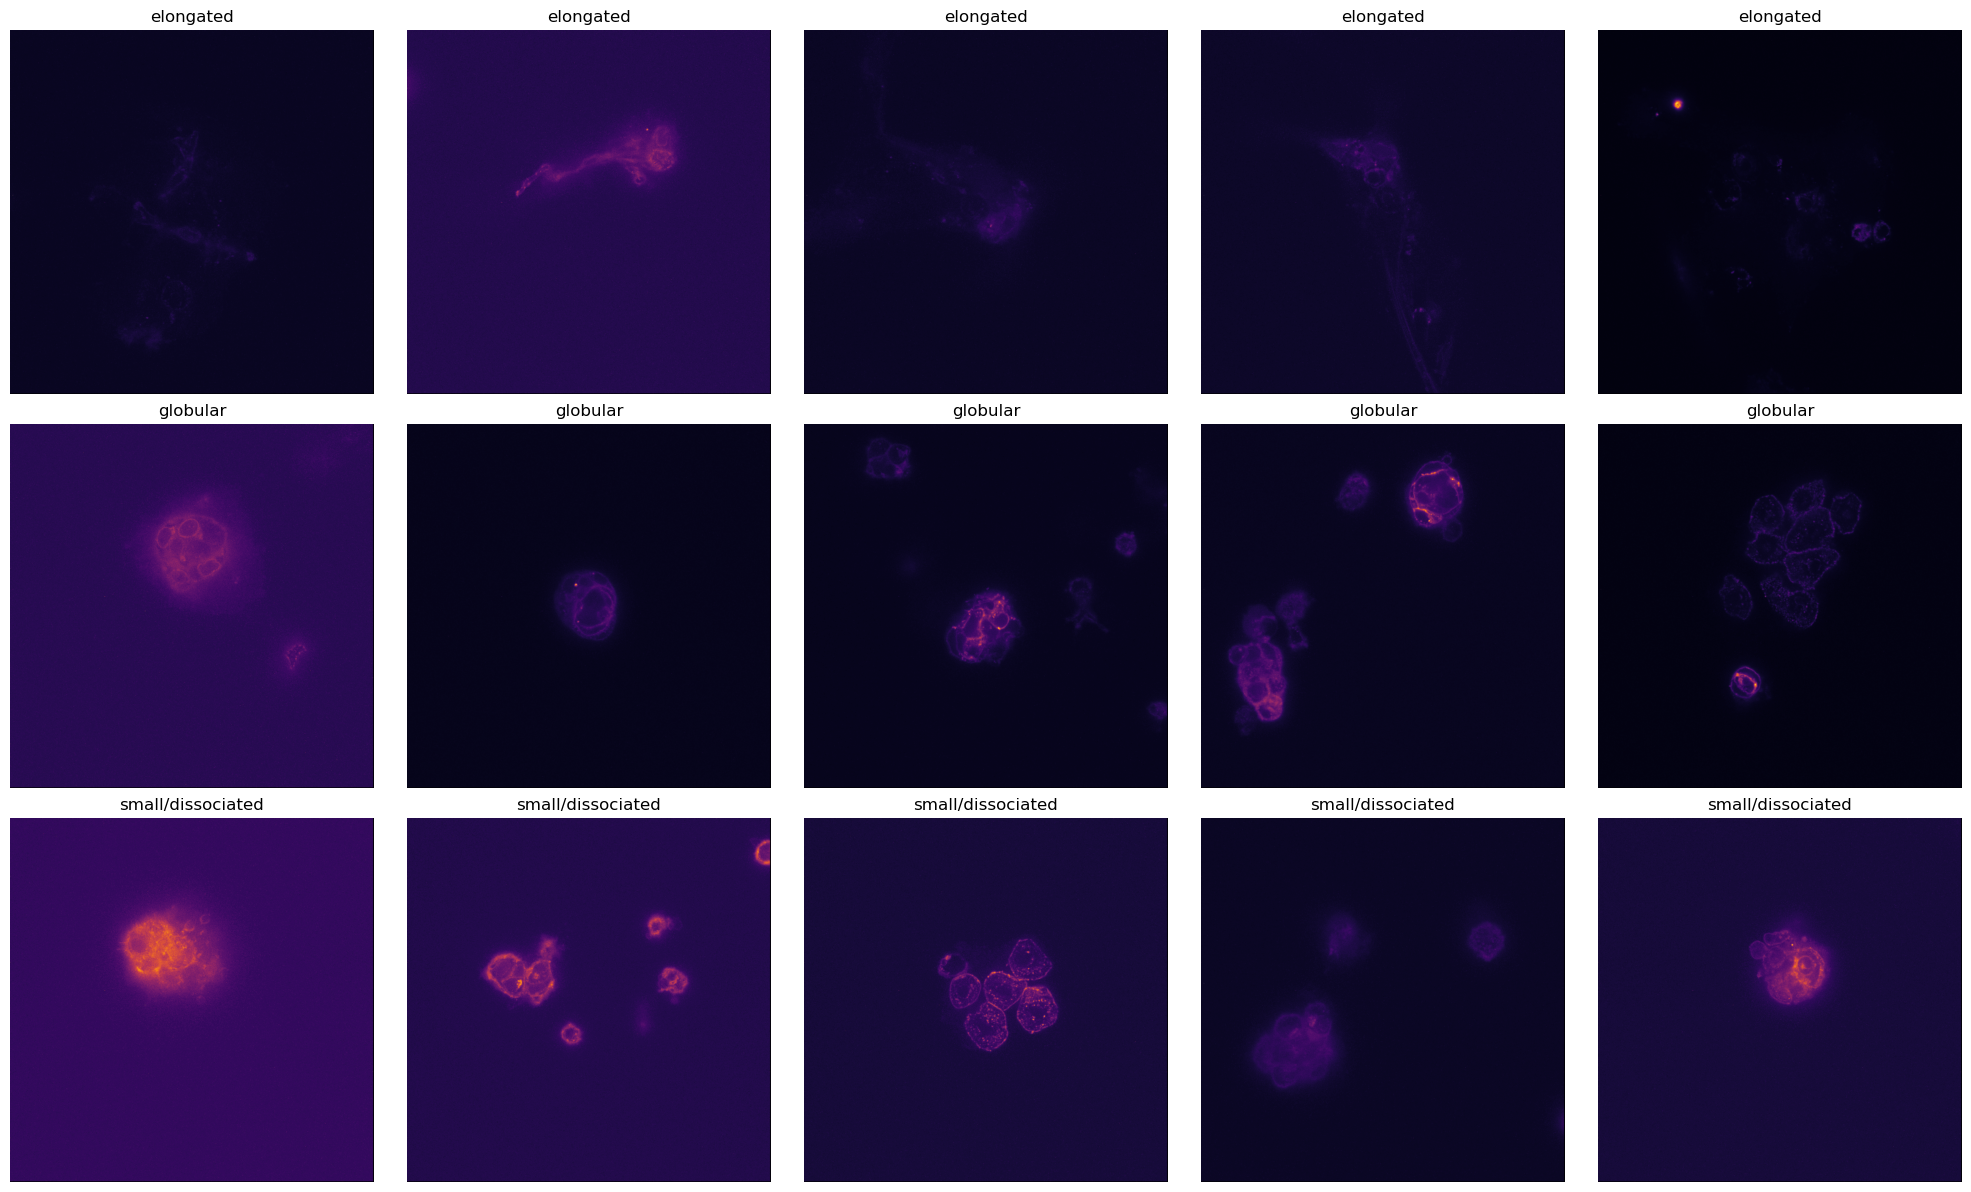

In [11]:
# pick three random images from each predicted class to show
label_names = {0: "globular", 1: "small/dissociated", 2: "elongated"}
rng = np.random.default_rng(0)
samples_per_class = 5

sampled_rows = []
for pred_label, group in all_preds_df.groupby("prediction"):
    n = min(samples_per_class, len(group))
    sampled_rows.append(group.sample(n=n, random_state=rng.integers(0, 1_000_000)))

sampled_df = pd.concat(sampled_rows, ignore_index=True)

n_classes = len(sampled_df["prediction"].unique())
fig, axes = plt.subplots(
    n_classes, samples_per_class, figsize=(4 * samples_per_class, 4 * n_classes)
)
if n_classes == 1:
    axes = np.array([axes])

for row_idx, (pred_label, group) in enumerate(sampled_df.groupby("prediction")):
    group = group.reset_index(drop=True)
    for col_idx in range(samples_per_class):
        ax = axes[row_idx, col_idx]
        if col_idx >= len(group):
            ax.axis("off")
            continue
        image_path = group.loc[col_idx, "image_path"]
        img = read_zstack_image(image_path)
        mid = img[img.shape[0] // 2]
        ax.imshow(mid, cmap="inferno")
        ax.axis("off")
        title = label_names.get(pred_label, str(pred_label))
        ax.set_title(title)

plt.tight_layout()
plt.show()